In [1]:
# builtins
import sys
import os
import time
import logging
from datetime import timedelta
from logging.config import dictConfig
import numpy as np
import datetime
import pathlib
import pandas as pd
import joblib
import plotly
import optuna
from sklearn.metrics import mean_squared_error
import math
import random

# externals
import xarray as xr

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# locals
from downscaleml.core.dataset import ERA5Dataset, NetCDFDataset, EoDataset

from downscaleml.main.config import (NET, ERA5_PLEVELS, ERA5_PREDICTORS, PREDICTAND,
                                     CALIB_PERIOD, VALID_PERIOD, DOY, NORM,
                                     OVERWRITE, DEM, DEM_FEATURES, STRATIFY,
                                     WET_DAY_THRESHOLD, VALID_SIZE, 
                                     start_year, end_year, CHUNKS, combination, params)

from downscaleml.main.inputoutput import (ERA5_PATH, OBS_PATH, DEM_PATH, MODEL_PATH, TARGET_PATH)

from downscaleml.core.constants import (ERA5_P_VARIABLES, ERA5_P_VARIABLES_SHORTCUT, ERA5_P_VARIABLE_NAME,
                                        ERA5_S_VARIABLES, ERA5_S_VARIABLES_SHORTCUT, ERA5_S_VARIABLE_NAME,
                                        ERA5_VARIABLES, ERA5_VARIABLE_NAMES, ERA5_PRESSURE_LEVELS,
                                        PREDICTANDS, ERA5_P_VARIABLES, ERA5_S_VARIABLES)

from downscaleml.core.utils import NAMING_Model, normalize, search_files, LogConfig
from downscaleml.core.logging import log_conf

from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score
    
# module level logger
LOGGER = logging.getLogger(__name__)

def stacker(xarray_dataset):
    # stack along the lat and lon dimensions
    stacked = xarray_dataset.stack()
    dask_arr = stacked.to_array().data
    xarray_dataset = dask_arr.T
    LogConfig.init_log('Shape of the numpy array is in (spatial, time, variables):{}'.format(xarray_dataset.shape))
    return xarray_dataset

def doy_encoding(X, y=None, doy=False):

    # whether to include the day of the year as predictor variable
    if doy:
        # add doy to set of predictor variables
        LOGGER.info('Adding day of the year to predictor variables ...')
        X = X.assign(EoDataset.encode_doys(X, chunks=X.chunks))

    print(X)
    return X

if __name__ == '__main__':

    # initialize timing
    start_time = time.monotonic()
        
    # initialize network filename
    state_file = NAMING_Model.state_file(
        NET, PREDICTAND, ERA5_PREDICTORS, ERA5_PLEVELS, WET_DAY_THRESHOLD, dem=DEM,
        dem_features=DEM_FEATURES, doy=DOY, stratify=STRATIFY)
    
    state_file = MODEL_PATH.joinpath(PREDICTAND, state_file)
    target = TARGET_PATH.joinpath(PREDICTAND)

    # check if output path exists
    if not target.exists():
        target.mkdir(parents=True, exist_ok=True)
    # initialize logging
    log_file = state_file.with_name(state_file.name + "_log.txt")
    
    if log_file.exists():
        log_file.unlink()
    dictConfig(log_conf(log_file))

    # check if target dataset already exists
    target = target.joinpath(state_file.name + '.nc')
    if target.exists() and not OVERWRITE:
        LogConfig.init_log('{} already exists.'.format(target))
        sys.exit()

    LogConfig.init_log('Initializing downscaling for period: {}'.format(
        ' - '.join([str(CALIB_PERIOD[0]), str(CALIB_PERIOD[-1])])))

    # initialize ERA5 predictor dataset
    LogConfig.init_log('Initializing ERA5 predictors.')
    Era5 = ERA5Dataset(ERA5_PATH.joinpath('ERA5'), ERA5_PREDICTORS,
                       plevels=ERA5_PLEVELS)
    Era5_ds = Era5.merge(chunks=CHUNKS)
    Era5_ds = Era5_ds.rename({'lon': 'x','lat': 'y'})
    
    # initialize OBS predictand dataset
    LogConfig.init_log('Initializing observations for predictand: {}'
                       .format(PREDICTAND))

    # read in-situ gridded observations
    Obs_ds = search_files(OBS_PATH.joinpath(PREDICTAND), '.nc$').pop()
    Obs_ds = xr.open_dataset(Obs_ds)
    Obs_ds = Obs_ds.rename({'lon': 'x','lat': 'y'})

    # whether to use digital elevation model
    if DEM:
        # digital elevation model: Copernicus EU-Dem v1.1
        dem = search_files(DEM_PATH, '^interTwin_dem.nc$').pop()

        # read elevation and compute slope and aspect
        dem = ERA5Dataset.dem_features(
            dem, {'y': Era5_ds.y, 'x': Era5_ds.x},
            add_coord={'time': Era5_ds.time})

        # check whether to use slope and aspect
        if not DEM_FEATURES:
            dem = dem.drop_vars(['slope', 'aspect']).chunk(Era5_ds.chunks)

        # add dem to set of predictor variables
        dem = dem.chunk(Era5_ds.chunks)
        Era5_ds = xr.merge([Era5_ds, dem])

    # initialize training data
    LogConfig.init_log('Initializing training data.')

    # split calibration period into training and validation period
    if PREDICTAND == 'pr' and STRATIFY:
        # stratify training and validation dataset by number of
        # observed wet days for precipitation
        wet_days = (Obs_ds.sel(time=CALIB_PERIOD).mean(dim=('y', 'x'))
                    >= WET_DAY_THRESHOLD).to_array().values.squeeze()
        train, valid = train_test_split(
            CALIB_PERIOD, stratify=wet_days, test_size=VALID_SIZE)

        # sort chronologically
        train, valid = sorted(train), sorted(valid)
        Era5_train, Obs_train = Era5_ds.sel(time=train), Obs_ds.sel(time=train)
        Era5_valid, Obs_valid = Era5_ds.sel(time=valid), Obs_ds.sel(time=valid)
    else:
        LogConfig.init_log('We are not calculating Stratified Precipitation based on Wet Days here!')

    # training and validation dataset
    Era5_train, Obs_train = Era5_ds.sel(time=CALIB_PERIOD), Obs_ds.sel(time=CALIB_PERIOD)
    Era5_valid, Obs_valid = Era5_ds.sel(time=VALID_PERIOD), Obs_ds.sel(time=VALID_PERIOD)

    Era5_train = doy_encoding(Era5_train, Obs_train, doy=DOY)
    Era5_valid = doy_encoding(Era5_valid, Obs_valid, doy=DOY)

    predictors_train = Era5_train
    predictors_valid = Era5_valid
    predictand_train = Obs_train
    predictand_valid = Obs_valid
    
    predictors_train = stacker(predictors_train).compute()
    predictors_valid = stacker(predictors_valid).compute()
    predictand_train = stacker(predictand_train)
    predictand_valid = stacker(predictand_valid)
    
    LogConfig.init_log('Dask computations done!')
    # iterate over the grid points
    LogConfig.init_log('Downscaling by Random Forest Starts: iterating each grid cell over time dimension')
    
    Models = {
        'RandomForestRegressor' : RandomForestRegressor,
        'XGBRegressor' : XGBRegressor,
        'AdaBoostRegressor': AdaBoostRegressor,
        'LGBMRegressor': LGBMRegressor,
    }
    Model_name = NET

/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-20T06:44:29: Initializing downscaling for period: 1985-01-01 - 2015-12-31
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-20T06:44:29: Initializing ERA5 predictors.
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: Searching: /mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/p_REANALYSIS/ERA5/geo

<xarray.Dataset>
Dimensions:    (time: 11322, x: 161, y: 96)
Coordinates:
  * time       (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2015-12-31
  * x          (x) float64 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
  * y          (y) float64 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
Data variables: (12/17)
    z_500      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    z_850      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    t_500      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    t_850      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    u_500      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    u_850      (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    ...         ...
    tp         (time, y, x) float32 dask.array<chunksize=(364, 96, 161), meta=np.ndarray>
    elevation  (time, 

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-20T06:45:03: Shape of the numpy array is in (spatial, time, variables):(161, 96, 11322, 17)
downscaleml.core.utils: --------------------------------------------------------------------------------


<xarray.Dataset>
Dimensions:    (time: 1826, x: 161, y: 96)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * x          (x) float64 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
  * y          (y) float64 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
Data variables: (12/17)
    z_500      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    z_850      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    t_500      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    t_850      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    u_500      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    u_850      (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    ...         ...
    tp         (time, y, x) float32 dask.array<chunksize=(357, 96, 161), meta=np.ndarray>
    elevation  (time, y

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-20T06:48:32: Shape of the numpy array is in (spatial, time, variables):(161, 96, 1826, 17)
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-20T06:49:06: Shape of the numpy array is in (spatial, time, variables):(161, 96, 11322, 1)
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-20T06:49:07: Shape of the numpy array is in (spatial, time, variables):(161, 96, 1826, 1)
downscaleml.core.utils: --------------------------------------------------------------------------------
do

CV Steps - 5 KFold cross validation

In [2]:

random.seed(42)

def grid_creator(combinations, numpy_object):
    gridded = np.ones(shape=(int(math.sqrt(combinations)), int(math.sqrt(combinations)), numpy_object.shape[2], numpy_object.shape[3])) * np.nan
    return gridded


predictors_train_grid = grid_creator(combination, predictors_train)
predictand_train_grid = grid_creator(combination, predictand_train)
predictors_valid_grid = grid_creator(combination, predictors_valid)
predictand_valid_grid = grid_creator(combination, predictand_valid)

def generate_unique_random_array(size, lower_bound, upper_bound, seed=None):

    if size > upper_bound - lower_bound:
        raise ValueError("Cannot generate more unique values than the range size.")

    if seed is not None:
        random.seed(seed)

    unique_values = set()

    while len(unique_values) < size:
        unique_values.add(random.randint(lower_bound, upper_bound))

    # Convert the set to a list and return it
    return list(unique_values)

# Define a seed value (or choose any other value)
seed_value = 42

x = generate_unique_random_array(int(math.sqrt(combination)), 0, (predictand_train.shape[0] - 1), seed_value)
y = generate_unique_random_array(int(math.sqrt(combination)), 0, (predictand_train.shape[1] - 1), seed_value)

print(x,y)


for i in range(int(math.sqrt(combination))):
    for j in range(int(math.sqrt(combination))):
        predictors_train_grid[i][j] = predictors_train[x[i], y[j], :, :]
        predictand_train_grid[i][j] = predictand_train[x[i], y[j], :, :]
        predictors_valid_grid[i][j] = predictors_valid[x[i], y[j], :, :] 
        predictand_valid_grid[i][j] = predictand_valid[x[i], y[j], :, :]

[35, 70, 6, 139, 22, 151, 57, 26, 28, 62] [3, 35, 13, 14, 81, 17, 86, 28, 94, 31]


In [3]:
predictand_valid.shape

(161, 96, 1826, 1)

In [4]:
lon, lat = np.squeeze(Obs_valid.x.values), np.squeeze(Obs_valid.y.values)

In [5]:
grid_x, grid_y = lon[x], lat[y]

In [6]:
reduced_grid_x = xr.DataArray(grid_x, dims=('x'))
reduced_grid_y = xr.DataArray(grid_y, dims=('y'))

Single Model - Iterating over all the grids

-
prediction = np.ones(shape=(predictand_valid_grid.shape[2], predictand_valid_grid.shape[1], predictand_valid_grid.shape[0])) * np.nan
model = Models[Model_name]()
r2_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))
mae_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))

for i in range(predictors_train_grid.shape[0]):
    for j in range(predictors_train_grid.shape[1]):

        point_predictors = predictors_train_grid[i, j, :, :]
        point_predictand = predictand_train_grid[i, j, :, :]

        # check if the grid point is valid
        if np.isnan(point_predictors).any() or np.isnan(point_predictand).any():
            # move on to next grid point
            continue

        # prepare predictors of validation period
        point_validation = predictors_valid_grid[i, j, :, :]
        #point_validation = normalize(point_validation)

        predictand_validation = predictand_valid_grid[i, j, :, :]

        LogConfig.init_log('Current grid point: ({:d}), ({:d}) '.format(i, j))    
        # normalize each predictor variable to [0, 1]
        # point_predictors = normalize(point_predictors)
        # instanciate the model for the current grid point

        # train model on training data
        model.fit(point_predictors, point_predictand)
        # predict validation period
        pred = model.predict(point_validation)
        
        LogConfig.init_log('Processing grid point: {:d}, {:d} - score: {:.2f}'.format(i, j, r2_score(predictand_validation, pred)))
        r2_values[i][j] = r2_score(predictand_validation, pred)
        LogConfig.init_log('Processing grid point: {:d}, {:d} - score: {:.2f}'.format(i, j, mean_absolute_error(predictand_validation, pred)))
        mae_values[i][j] = mean_absolute_error(predictand_validation, pred)
        # store predictions for current grid point
        prediction[:, j, i] = pred


model.get_params()

np.mean(mae_values)

Using Optuna for Hyperparameter Optimising

In [7]:
predictand_train_grid.shape, predictors_train_grid.shape

((10, 10, 11322, 1), (10, 10, 11322, 17))

In [8]:


predictors_train_grid = predictors_train_grid.transpose(2, 1, 0, 3)
predictand_train_grid = predictand_train_grid.transpose(2, 1, 0, 3)
predictors_valid_grid = predictors_valid_grid.transpose(2, 1, 0, 3)
predictand_valid_grid = predictand_valid_grid.transpose(2, 1, 0, 3)
train_x, test_x, train_y, test_y = train_test_split(predictors_train_grid, predictand_train_grid, test_size=0.2,random_state=42)


In [9]:
np.squeeze(predictand_valid_grid).shape

(1826, 10, 10)

In [10]:
-
def objective(trial,data=predictors_train_grid,target=predictand_train_grid):

    #General parameters that would fit in any data
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'rmse', 
        'random_state': 48,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100),
        'verbose' : -1,
        'early_stopping' : 100
    }

    model = LGBMRegressor(**param)
    rmse_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))
    
    for i in range(train_x.shape[1]):
        for j in range(train_x.shape[2]):

            point_predictors = train_x[:, j, i, :]
            point_predictand = train_y[:, j, i, :]
    
            # check if the grid point is valid
            if np.isnan(point_predictors).any() or np.isnan(point_predictand).any():
                # move on to next grid point
                continue
    
            # prepare predictors of validation period
            point_validation = test_x[:, j, i, :]
            #point_validation = normalize(point_validation)

            predictand_validation = test_y[:, j, i, :]

            LogConfig.init_log('Current grid point: ({:d}), ({:d}) '.format(i, j))    
            # normalize each predictor variable to [0, 1]
            # point_predictors = normalize(point_predictors)
            # instanciate the model for the current grid point
    
            # train model on training data
    
            model.fit(point_predictors,np.squeeze(point_predictand),eval_set=[(point_validation,predictand_validation)])
    
            preds = model.predict(point_validation)
            
            rmse = mean_squared_error(predictand_validation, preds,squared=False)
            rmse_values[i][j] = rmse
            mean_rmse = np.mean(rmse_values)
            
    return mean_rmse

SyntaxError: invalid syntax (4123644330.py, line 1)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

In [ ]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study.trials_dataframe().to_csv("output.csv", index=False) 


In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
params=study.best_params   
params

In [ ]:
params['random_state'] = 48
params['n_estimators'] = 20000 
params['metric'] = 'rmse'


In [ ]:
params['cat_smooth'] = params.pop('min_data_per_groups')


In [ ]:
params

In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_parallel_coordinate(study)


In [ ]:
optuna.visualization.plot_slice(study)


In [ ]:
optuna.visualization.plot_contour(study, params=['num_leaves',
                            'max_depth',
                            'subsample',
                            'learning_rate',
                            'subsample'])

In [ ]:
optuna.visualization.plot_param_importances(study)


In [ ]:
optuna.visualization.plot_edf(study)


In [ ]:
predictand_valid_grid.shape

In [11]:
params

{'reg_alpha': 0.001018337175296235,
 'reg_lambda': 0.10078524608920145,
 'colsample_bytree': 0.7,
 'subsample': 0.8,
 'learning_rate': 0.01,
 'max_depth': 100,
 'num_leaves': 526,
 'min_child_samples': 59,
 'random_state': 48,
 'n_estimators': 20000,
 'metric': 'rmse',
 'cat_smooth': 91}

In [12]:
params['early_stopping'] = 100
params['verbose'] = -1
from sklearn.model_selection import TimeSeriesSplit

predictions = np.ones(shape=(predictand_valid_grid.shape[0], predictand_valid_grid.shape[1], predictand_valid_grid.shape[2])) * np.nan
LogConfig.init_log('predictions Shape check: {} '.format(predictions.shape))
tSS = TimeSeriesSplit(n_splits=10)
rmse_val = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))
model = LGBMRegressor(**params)

for i in range(predictors_train_grid.shape[1]):
    for j in range(predictors_train_grid.shape[2]):

        point_predictors = predictors_train_grid[:, j, i, :]
        point_predictand = predictand_train_grid[:, j, i, :]

        # check if the grid point is valid
        if np.isnan(point_predictors).any() or np.isnan(point_predictand).any():
            # move on to next grid point
            continue

        # prepare predictors of validation period
        point_validation = predictors_valid_grid[:, j, i, :]
        #point_validation = normalize(point_validation)

        predictand_validation = predictand_valid_grid[:, j, i, :]

        LogConfig.init_log('Current grid point: ({:d}), ({:d}) '.format(i, j))  
        
        preds = np.zeros(predictand_validation.shape[0])
        rmse=[]
        LogConfig.init_log('Shape check: {} '.format(point_validation.shape))
        for trn_idx, test_idx in tSS.split(point_predictors,point_predictand):
            X_tr,X_val=point_predictors[trn_idx],point_predictors[test_idx]
            y_tr,y_val=point_predictand[trn_idx],point_predictand[test_idx]
            model.fit(X_tr,np.squeeze(y_tr),eval_set=[(X_val,y_val)])
            rmse.append(mean_squared_error(y_val, model.predict(X_val), squared=False))           
        
        preds=model.predict(point_validation)
        rmse_val[i][j] = np.mean(rmse)
        LogConfig.init_log('Current grid point: ({:d}), ({:d}) RMSE over KFold: {} '.format(i, j, rmse_val[i][j]))
        LogConfig.init_log('What check preds: {} '.format(preds.shape))
        predictions[:, j, i] = preds

downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-20T06:51:39: predictions Shape check: (1826, 10, 10) 
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-20T06:51:39: Current grid point: (0), (0) 
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: --------------------------------------------------------------------------------
downscaleml.core.utils: 2024-02-20T06:51:39: Shape check: (1826, 17) 
downscaleml.core.utils: --------------------------------------------------------------------------------
/home/sdhinakaran/micromamba/envs/check/lib/python3.11/site-packages/lightgbm/basic.py:300: UserWarning: Converting column-vector to 1d arr

In [13]:
predictions.shape

(1826, 10, 10)

In [14]:
predictand_valid_grid.shape

(1826, 10, 10, 1)

predictand_valid_grid = np.squeeze(predictand_valid_grid)

r2_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))
mae_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))
mse_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))


for i in range(predictors_train_grid.shape[1]):
    for j in range(predictors_train_grid.shape[2]):
        r2_values[i][j] = r2_score(predictand_valid_grid[:, j, i], predictions[:, j, i])
        mae_values[i][j] = mean_absolute_error(predictand_valid_grid[:, j, i], predictions[:, j, i])
        mse_values[i][j] = mean_squared_error(predictand_valid_grid[:, j, i], predictions[:, j, i])

mean_values = np.ones(shape=(int(math.sqrt(combination)), int(math.sqrt(combination))))

for i in range(predictors_train_grid.shape[1]):
    for j in range(predictors_train_grid.shape[2]):
        mean_values[i][j] = np.mean(predictand_valid_grid[:, j, i])
        

mean_values

In [15]:
reduced_grid_y

<xarray.DataArray (y: 10)>
array([43.8214274 , 45.96941476, 44.49267345, 44.55979805, 49.05714659,
       44.76117187, 49.39276962, 45.49954252, 49.92976646, 45.70091634])
Dimensions without coordinates: y

In [16]:
# store predictions in xarray.Dataset
prediction = xr.DataArray(data=predictions, dims=['time', 'y', 'x'],
                        coords=dict(time=pd.date_range(Era5_valid.time.values[0],Era5_valid.time.values[-1], freq='D'),
                                    lat=reduced_grid_y, lon=reduced_grid_x))
prediction = prediction.to_dataset(name=PREDICTAND)

prediction = prediction.set_index(
    time='time',
    y='lat',
    x='lon'
)

y_pred = prediction

y_true = xr.DataArray(data=np.squeeze(predictand_valid_grid), dims=['time', 'y', 'x'],
                        coords=dict(time=pd.date_range(Era5_valid.time.values[0],Era5_valid.time.values[-1], freq='D'),
                                    lat=reduced_grid_y, lon=reduced_grid_x))
y_true = y_true.to_dataset(name=PREDICTAND)

y_true = y_true.set_index(
    time='time',
    y='lat',
    x='lon'
)



In [17]:
y_true

<xarray.Dataset>
Dimensions:  (time: 1826, y: 10, x: 10)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 43.82 45.97 44.49 44.56 49.06 ... 49.39 45.5 49.93 45.7
  * x        (x) float64 7.433 9.782 5.486 14.41 6.56 ... 8.91 6.829 6.963 9.245
Data variables:
    pr       (time, y, x) float64 8.608 1.405 4.147 0.0 ... 1.144 1.918 5.678

In [18]:
y_pred

<xarray.Dataset>
Dimensions:  (time: 1826, y: 10, x: 10)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 43.82 45.97 44.49 44.56 49.06 ... 49.39 45.5 49.93 45.7
  * x        (x) float64 7.433 9.782 5.486 14.41 6.56 ... 8.91 6.829 6.963 9.245
Data variables:
    pr       (time, y, x) float64 7.097 2.175 1.251 ... 1.256 0.8106 0.3868

In [19]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)

def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)


Starting year: 2016
Ending year: 2020


In [20]:
y_pred = y_pred.rename({'pr': 'precipitation'})
#y_pred

In [21]:
# Minor changes to be made to dataset to align and making it compliant
# y_true = y_true.drop_vars("spatial_ref")
y_true = y_true.rename({'pr': 'precipitation'})
#y_true = y_true.rename({'lon': 'x','lat': 'y'})
#y_true


In [22]:
y_true

<xarray.Dataset>
Dimensions:        (time: 1826, y: 10, x: 10)
Coordinates:
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y              (y) float64 43.82 45.97 44.49 44.56 ... 49.39 45.5 49.93 45.7
  * x              (x) float64 7.433 9.782 5.486 14.41 ... 6.829 6.963 9.245
Data variables:
    precipitation  (time, y, x) float64 8.608 1.405 4.147 ... 1.144 1.918 5.678

In [23]:
y_pred

<xarray.Dataset>
Dimensions:        (time: 1826, y: 10, x: 10)
Coordinates:
  * time           (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y              (y) float64 43.82 45.97 44.49 44.56 ... 49.39 45.5 49.93 45.7
  * x              (x) float64 7.433 9.782 5.486 14.41 ... 6.829 6.963 9.245
Data variables:
    precipitation  (time, y, x) float64 7.097 2.175 1.251 ... 0.8106 0.3868

In [24]:
# aligndata_varsasets
if len(y_pred.data_vars) > 1:
    y_true, y_pred_pr = xr.align(y_true.precipitation, y_pred.precipitation, join='override')
else:
    y_true, y_pred_pr = xr.align(y_true.precipitation, y_pred.precipitation, join='override')

In [25]:
# mask missing values
mask = ~np.isnan(y_true)
y_pred_pr = y_pred_pr.where(mask, other=np.nan)    
if len(y_pred.data_vars) > 1:
    y_pred_prob = y_pred_prob.where(mask, other=np.nan)

In [26]:
# calculate monthly precipitation (mm / month)
y_pred_m = y_pred_pr.resample(time='1M').sum(skipna=False)
y_true_m = y_true.resample(time='1M').sum(skipna=False)

In [27]:
# calculate mean annual cycle
y_pred_ac = y_pred_m.groupby('time.month').mean(dim=('y', 'x', 'time'), skipna=True).values.squeeze()
y_true_ac = y_true_m.groupby('time.month').mean(dim=('y', 'x', 'time'), skipna=True).values.squeeze()

In [28]:
import warnings

def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

# compute daily anomalies
y_pred_anom = anomalies(y_pred_pr, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [29]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_m.values.flatten()
y_true_mv = y_true_m.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 0.86
R2 on daily anomalies: 0.68


[Text(0, 0, 'January'),
 Text(1, 0, 'February'),
 Text(2, 0, 'March'),
 Text(3, 0, 'April'),
 Text(4, 0, 'May'),
 Text(5, 0, 'June'),
 Text(6, 0, 'July'),
 Text(7, 0, 'August'),
 Text(8, 0, 'September'),
 Text(9, 0, 'October'),
 Text(10, 0, 'November'),
 Text(11, 0, 'December')]

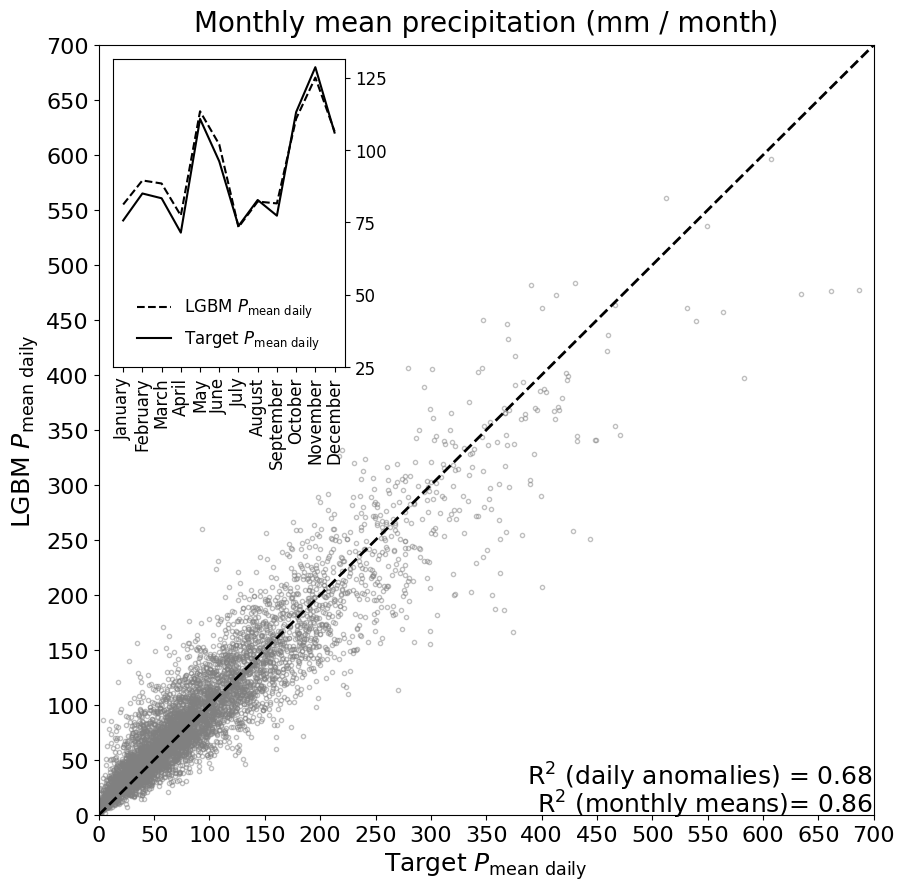

In [30]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score
import calendar

# dataset names mapping
PRED = 'LGBM $P_{\mathrm{mean \ daily}}$'
TRUE = 'Target $P_{\mathrm{mean \ daily}}$'

NAMES = {'pr': 'precipitation'}

# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot only a subset of data: otherwise plot is overloaded ...
# subset = np.random.choice(np.arange(0, len(y_pred_values)), size=int(1e3), replace=False)
# ax.plot(y_true_values[subset], y_pred_values[subset], 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot 1:1 mapping line
interval = np.arange(0, 750, 50)
ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 2, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 27.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)

# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel(TRUE, fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (mm / month)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="30%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac, ls='--', color='k', label=PRED)
axins.plot(y_true_ac, ls='-', color='k', label=TRUE)
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.set_yticks(np.arange(25, 150, 25))
axins.set_yticklabels(np.arange(25, 150, 25), fontsize=12)
axins.yaxis.tick_right()
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)

# save figure
#fig.savefig('../Notebooks/Figures/{}_r2.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Coefficient of determination: Spatially

In [31]:
# iterate over the grid points
r2 = np.ones((2, len(y_pred_m.x), len(y_pred_m.y)), dtype=np.float32) * np.nan
for i, _ in enumerate(y_pred_m.x):
    for j, _ in enumerate(y_pred_m.y):
        # get observed and predicted monthly precipitation for current grid point
        point_true = y_true_m.isel(x=i, y=j)
        point_pred = y_pred_m.isel(x=i, y=j)
        
        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, i, j] = r2_score(point_true, point_pred)
        r2[1, i, j] = r2_score(point_anom_true, point_anom_pred)

/tmp/ipykernel_213657/1214907451.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grn = cm.get_cmap('Greens', 128)
/tmp/ipykernel_213657/1214907451.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red = cm.get_cmap('Reds_r', 128)


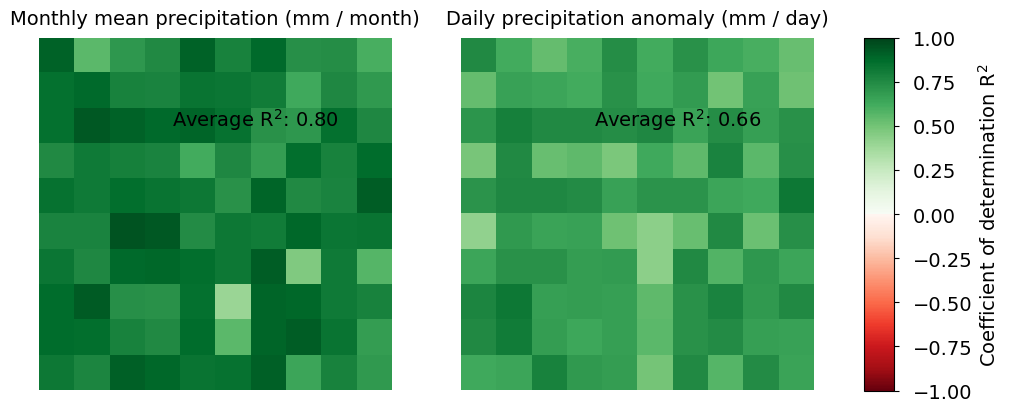

In [32]:
# define color map: red to green
grn = cm.get_cmap('Greens', 128)
red = cm.get_cmap('Reds_r', 128)
red2green = ListedColormap(np.vstack((red(np.linspace(0, 1, 128)),
                                      grn(np.linspace(0, 1, 128)))))

# plot coefficients of determination
vmin, vmax = -1, 1
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# monthly means
im0 = ax[0].imshow(r2[0, :], origin='upper', cmap=red2green, vmin=vmin, vmax=vmax)
ax[0].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), fontsize=14, ha='right');
ax[0].set_axis_off()
ax[0].set_title('Monthly mean {} (mm / month)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# daily anomalies
im1 = ax[1].imshow(r2[1, :], origin='upper', cmap=red2green, vmin=vmin, vmax=vmax)
ax[1].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), fontsize=14, ha='right');
ax[1].set_axis_off()
ax[1].set_title('Daily {} anomaly (mm / day)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# add colorbar 
cbar_ax_bias = fig.add_axes([ax[1].get_position().x1 + 0.05, ax[1].get_position().y0,
                             0.03, ax[1].get_position().y1 - ax[1].get_position().y0])
cbar_bias = fig.colorbar(im0, cax=cbar_ax_bias)
cbar_bias.set_label(label='Coefficient of determination R$^2$', fontsize=14)
cbar_bias.ax.tick_params(labelsize=14, pad=10)

# save figure
#fig.savefig('../Notebooks/Figures/{}_r2_spatial.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [33]:
# average bias of daily precipitation over reference period
y_pred_yearly_avg = y_pred_pr.groupby('time.year').mean(dim='time')
#y_refe_yearly_avg = y_refe.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = ((y_pred_yearly_avg - y_true_yearly_avg) / y_true_yearly_avg) * 100
print('({}:{}) Yearly average relative bias: {:.2f}%'.format(TRUE, PRED, bias_yearly_avg.mean().item()))

(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Yearly average relative bias: 4.12%


In [34]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg)
print('({}:{}) Yearly average MAE: {:.2f} mm'.format(TRUE, PRED, mae_avg.mean().item()))

(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Yearly average MAE: 0.26 mm


In [35]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE: {:.2f} mm / day'.format(TRUE, PRED, rmse_avg.item()))

(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Yearly average RMSE: 0.35 mm / day


In [36]:
# Pearson's correlation coefficient over reference period
for year in y_pred_yearly_avg.year:
    y_p = y_pred_yearly_avg.sel(year=year).values        
    y_t = y_true_yearly_avg.sel(year=year).values
    r, _ = stats.pearsonr(y_p[~np.isnan(y_p)], y_t[~np.isnan(y_t)])
    print('({:0d}) Pearson correlation: {:.2f}'.format(year.item(), np.asarray(r).mean()))
r, _ = stats.pearsonr(y_pred_yearly_avg.values[~np.isnan(y_pred_yearly_avg.values)],
                      y_true_yearly_avg.values[~np.isnan(y_true_yearly_avg.values)])
print('Total: {:.2f}'.format(r))

(2016) Pearson correlation: 0.97
(2017) Pearson correlation: 0.96
(2018) Pearson correlation: 0.96
(2019) Pearson correlation: 0.96
(2020) Pearson correlation: 0.96
Total: 0.96


Text(8, 12, 'RMSE = 0.4mm day$^{-1}$')

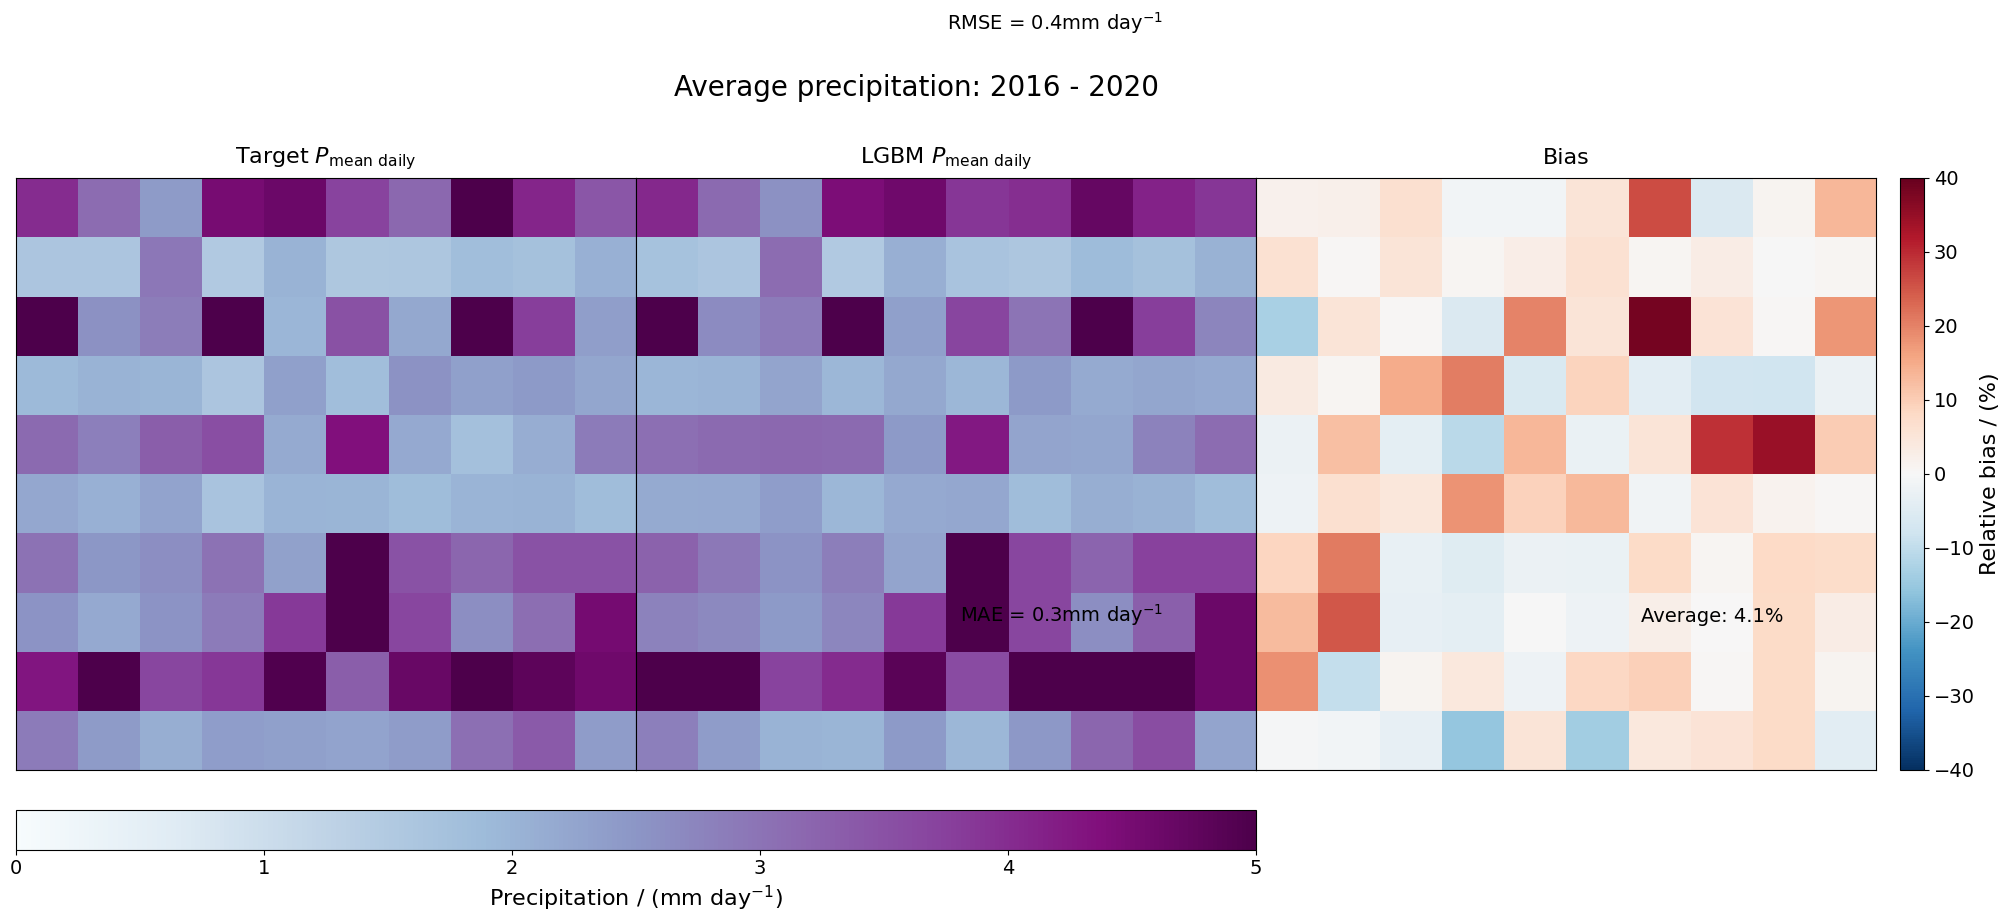

In [37]:
# plot average of observation, prediction, and bias
vmin, vmax = 0, 5
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_yearly_avg, y_pred_yearly_avg, bias_yearly_avg], axes):
    if ds is bias_yearly_avg:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-40, vmax=40)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='lower', cmap='BuPu', vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average {}: {} - {}'.format(NAMES[PREDICTAND],start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Relative bias / (%)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / '.format(NAMES[PREDICTAND].capitalize()) + '(mm day$^{-1}$)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.1f}'.format(mae_avg.mean().item()) + 'mm day$^{-1}$', fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.1f}'.format(rmse_avg.mean().item()) + 'mm day$^{-1}$', fontsize=14, ha='right')

# save figure
#fig.savefig('../Notebooks/Figures/{}_bias.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Seasonal bias

Calculate seasonal bias:

In [38]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred_pr.groupby('time.season').mean(dim='time')
bias_snl = ((y_pred_snl - y_true_snl) / y_true_snl) * 100

In [39]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias for season {}: {:.1f}%'.format(TRUE, PRED, season.values.item(), bias_snl.sel(season=season).mean().item()))

(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Average bias for season DJF: 5.5%
(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Average bias for season JJA: 4.0%
(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Average bias for season MAM: 6.0%
(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Average bias for season SON: 1.0%


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

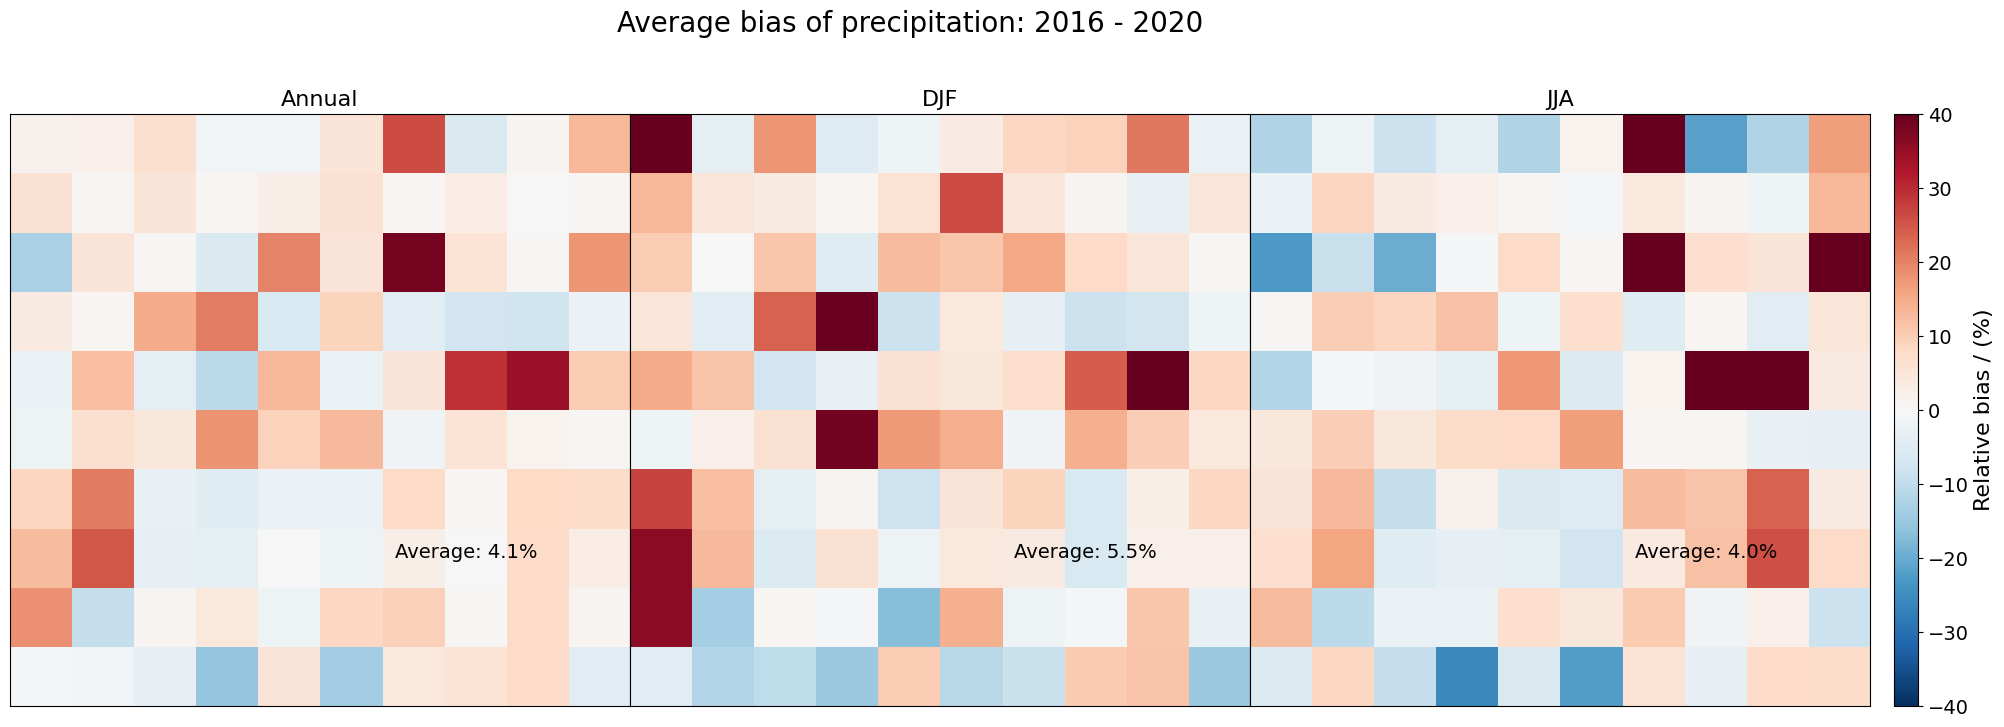

In [40]:
# plot seasonal differences
seasons = ('DJF', 'JJA')
fig, axes = plt.subplots(nrows=1, ncols=len(seasons) + 1, figsize=(24,8), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias
ds = bias_yearly_avg.mean(dim='year')
axes[0].imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-40, vmax=40)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias
for ax, season in zip(axes[1:], seasons):
    ds = bias_snl.sel(season=season)
    ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-40, vmax=40)
    ax.set_title(season, fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Relative bias / (%)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# save figure
#fig.savefig('../Notebooks/Figures/{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias of extreme values

In [41]:
# extreme quantile of interest
quantile = 0.98

In [42]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred_pr.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')

In [43]:
# calculate bias in extreme quantile for each year
bias_ex = ((y_pred_ex - y_true_ex) / y_true_ex) * 100

In [44]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f}: {:.1f}%'.format(TRUE, PRED, quantile * 100, bias_ex.mean().item()))

(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Yearly average bias for P98: -13.4%


In [45]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()

In [46]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f}: {:.1f} mm / day'.format(TRUE, PRED, quantile * 100, mae_ex.item()))

(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Yearly average MAE for P98: 4.2 mm / day


In [47]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())

In [48]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f}: {:.1f} mm / day'.format(TRUE, PRED, quantile * 100, rmse_ex.item()))

(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Yearly average RMSE for P98: 5.5 mm / day


Text(8, 12, 'RMSE = 5.5mm$^2$ day$^{-2}$')

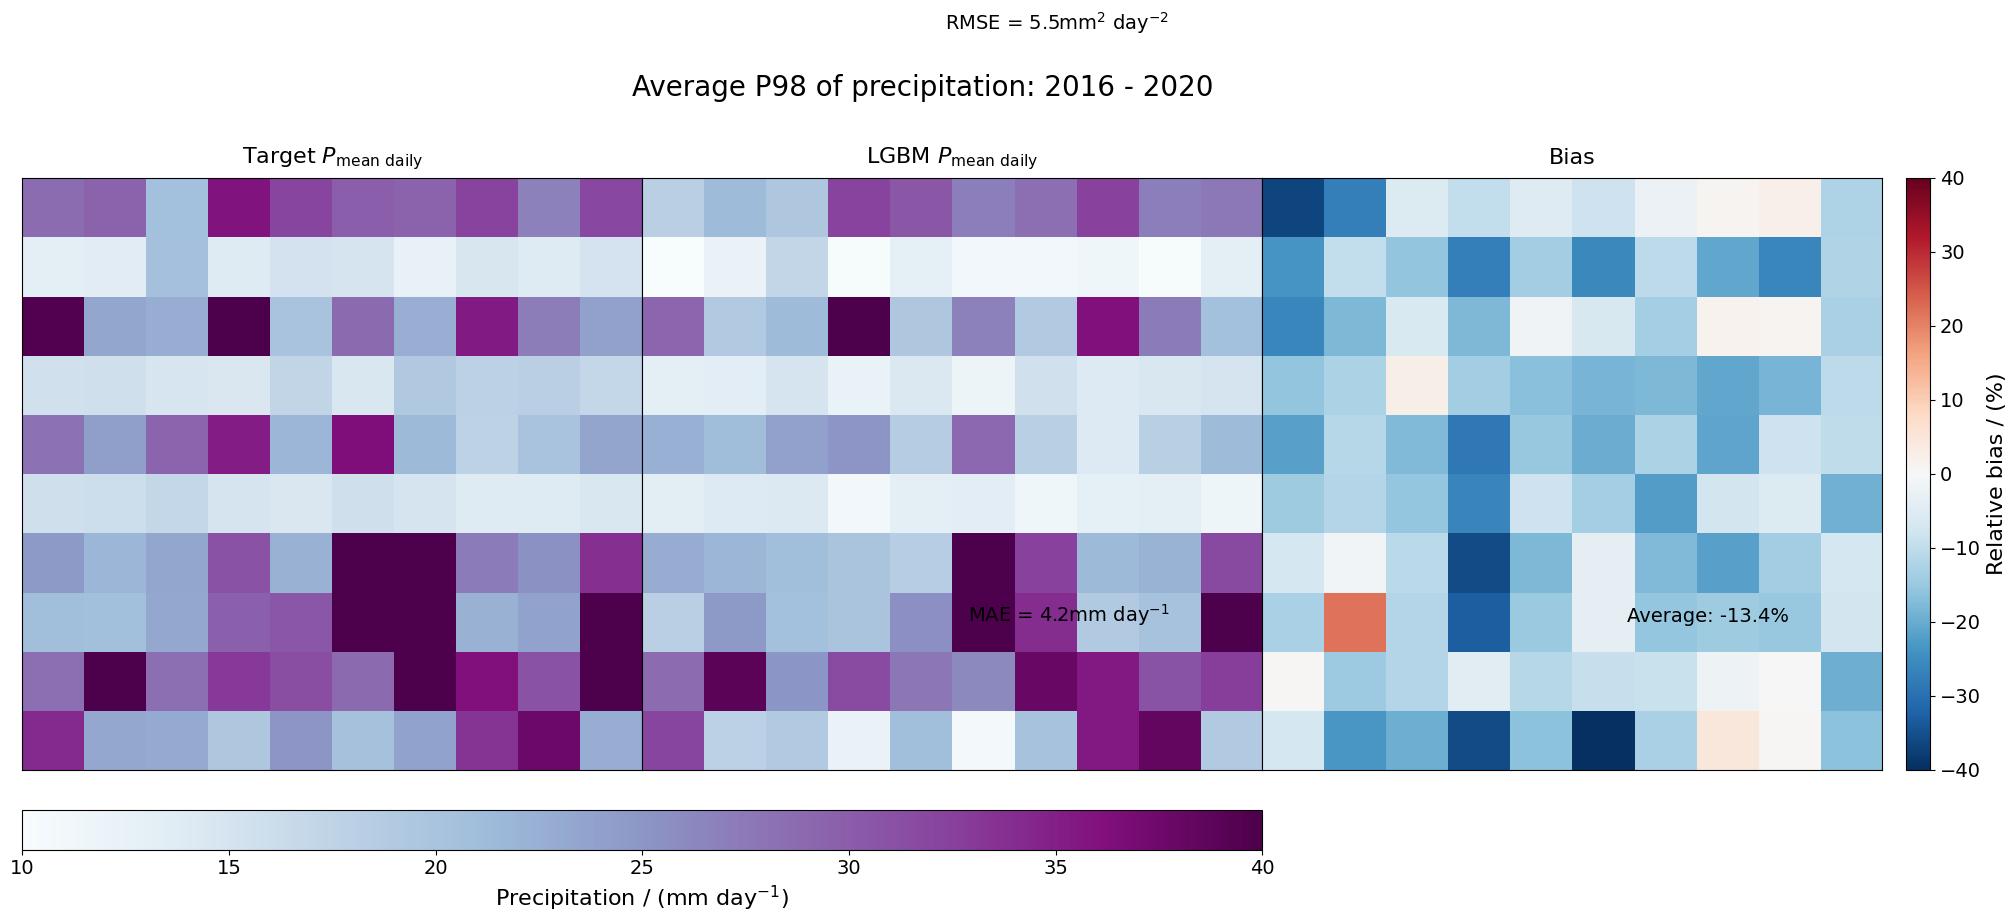

In [49]:
# plot extremes of observation, prediction, and bias
vmin, vmax = 10, 40
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_ex, y_pred_ex, bias_ex], axes):
    if ds is bias_ex:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-40, vmax=40)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='upper', cmap='BuPu', vmin=vmin, vmax=vmax)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year ), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Relative bias / (%)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / '.format(NAMES[PREDICTAND].capitalize()) + '(mm day$^{-1}$)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.1f}'.format(mae_ex.item())  + 'mm day$^{-1}$', fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.1f}'.format(rmse_ex.item())  + 'mm$^2$ day$^{-2}$', fontsize=14, ha='right')

# save figure
#fig.savefig('../Notebooks/Figures/{}_bias_p{:.0f}.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

### Bias of extremes: winter vs. summer

In [50]:
# group data by season and compute extreme percentile
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_true_ex_snl = y_true.groupby('time.season').quantile(quantile, dim='time')
    y_pred_ex_snl = y_pred_pr.groupby('time.season').quantile(quantile, dim='time')

In [51]:
# compute relative bias in seasonal extremes
bias_ex_snl = ((y_pred_ex_snl - y_true_ex_snl) / y_true_ex_snl) * 100

In [52]:
# print average bias in extreme per season: Insitu:CERRA
for season in bias_ex_snl.season:
    print('({}:{}) Average bias of P{:.0f} for season {}: {:.1f}%'.format(TRUE, PRED, quantile * 100, season.values.item(), bias_ex_snl.sel(season=season).mean().item()))

(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Average bias of P98 for season DJF: -8.9%
(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Average bias of P98 for season JJA: -26.2%
(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Average bias of P98 for season MAM: -15.2%
(Target $P_{\mathrm{mean \ daily}}$:LGBM $P_{\mathrm{mean \ daily}}$) Average bias of P98 for season SON: -11.5%


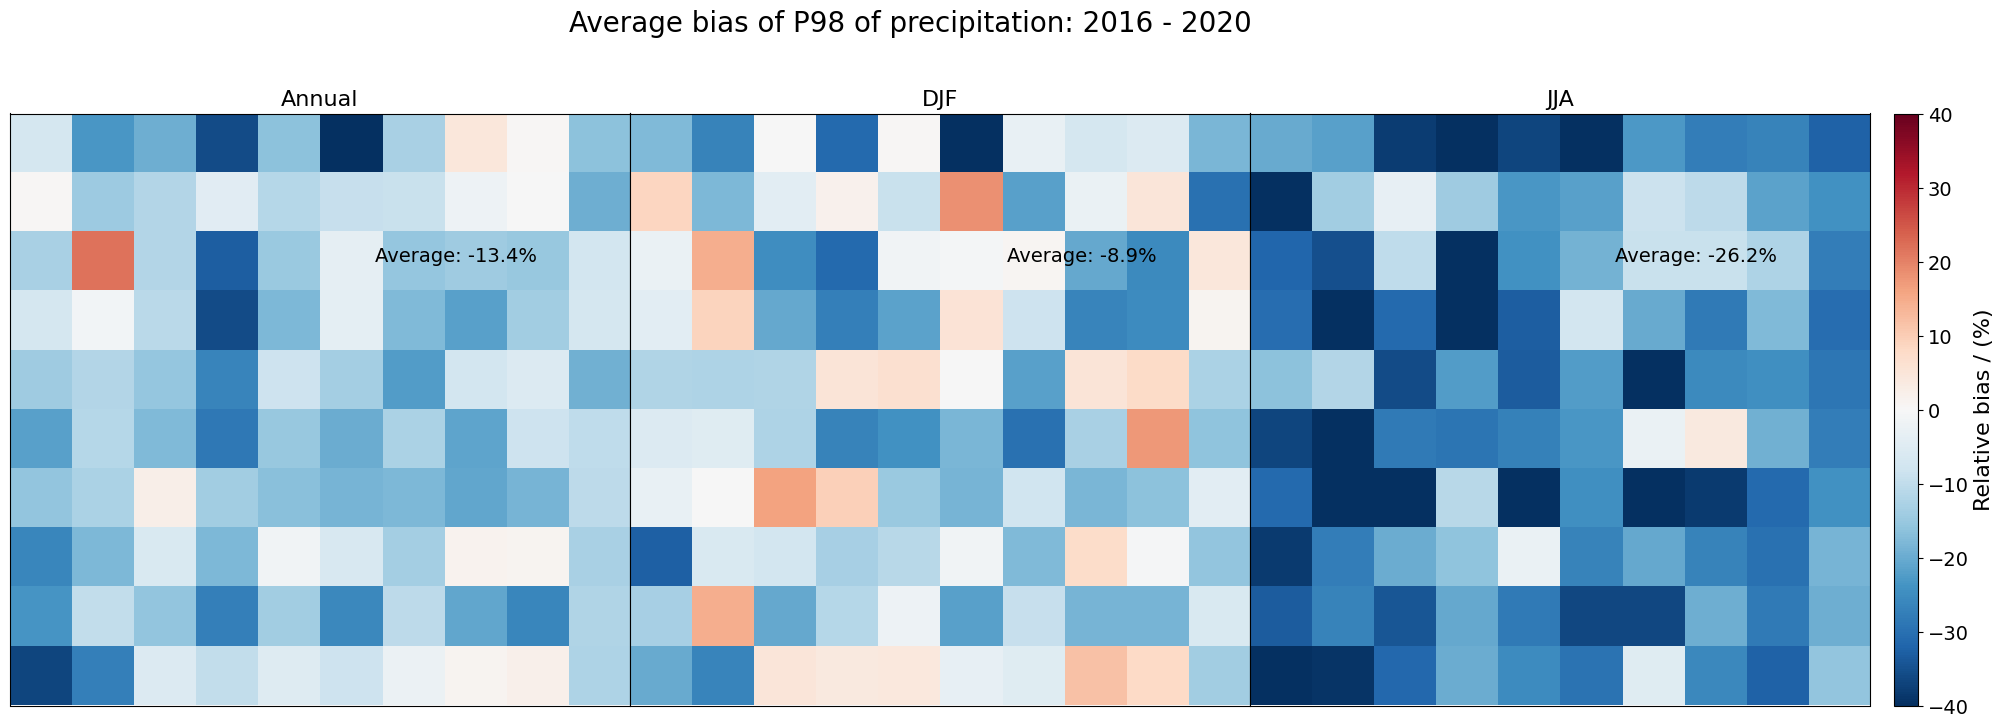

In [53]:
# plot seasonal differences
seasons = ('DJF', 'JJA')
fig, axes = plt.subplots(nrows=1, ncols=len(seasons) + 1, figsize=(24,8), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias of extreme
ds = bias_ex.mean(dim='year')
axes[0].imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-40, vmax=40)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias of extreme
for ax, season in zip(axes[1:], seasons):
    ds = bias_ex_snl.sel(season=season)
    ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-40, vmax=40)
    ax.set_title(season, fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Relative bias / (%)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# save figure
#fig.savefig('../Notebooks/Figures/{}_bias_p{:.0f}_seasonal.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

### Frequency of wet days

In [54]:
# minimum precipitation (mm / day) defining a wet day
WET_DAY_THRESHOLD = 1
WET_DAY_THRESHOLD = float(WET_DAY_THRESHOLD)

In [55]:
# true and predicted frequency of wet days
mask = (~np.isnan(y_true)) & (~np.isnan(y_pred_pr))
wet_days_true = (y_true >= WET_DAY_THRESHOLD).where(mask, other=np.nan).astype(np.float32)
wet_days_pred = (y_pred_pr >= WET_DAY_THRESHOLD).where(mask, other=np.nan).astype(np.float32)

In [56]:
# number of wet days in reference period: annual
n_wet_days_true = wet_days_true.sum(dim='time', skipna=False)
n_wet_days_pred = wet_days_pred.sum(dim='time', skipna=False)

In [57]:
# frequency of wet days in reference period: annual
f_wet_days_true = (n_wet_days_true / len(wet_days_true.time)) * 100
f_wet_days_pred = (n_wet_days_pred / len(wet_days_pred.time)) * 100

In [58]:
# frequency of wet days in reference period: seasonal
f_wet_days_true_snl = wet_days_true.groupby('time.season').mean(dim='time', skipna=False)
f_wet_days_pred_snl = wet_days_pred.groupby('time.season').mean(dim='time', skipna=False)

In [59]:
# relative bias of frequency of wet vs. dry days: annual
bias_wet = ((f_wet_days_pred - f_wet_days_true) / f_wet_days_true) * 100

# relative bias of frequency of wet vs. dry days: seasonal
bias_wet_snl = ((f_wet_days_pred_snl - f_wet_days_true_snl) / f_wet_days_true_snl) * 100

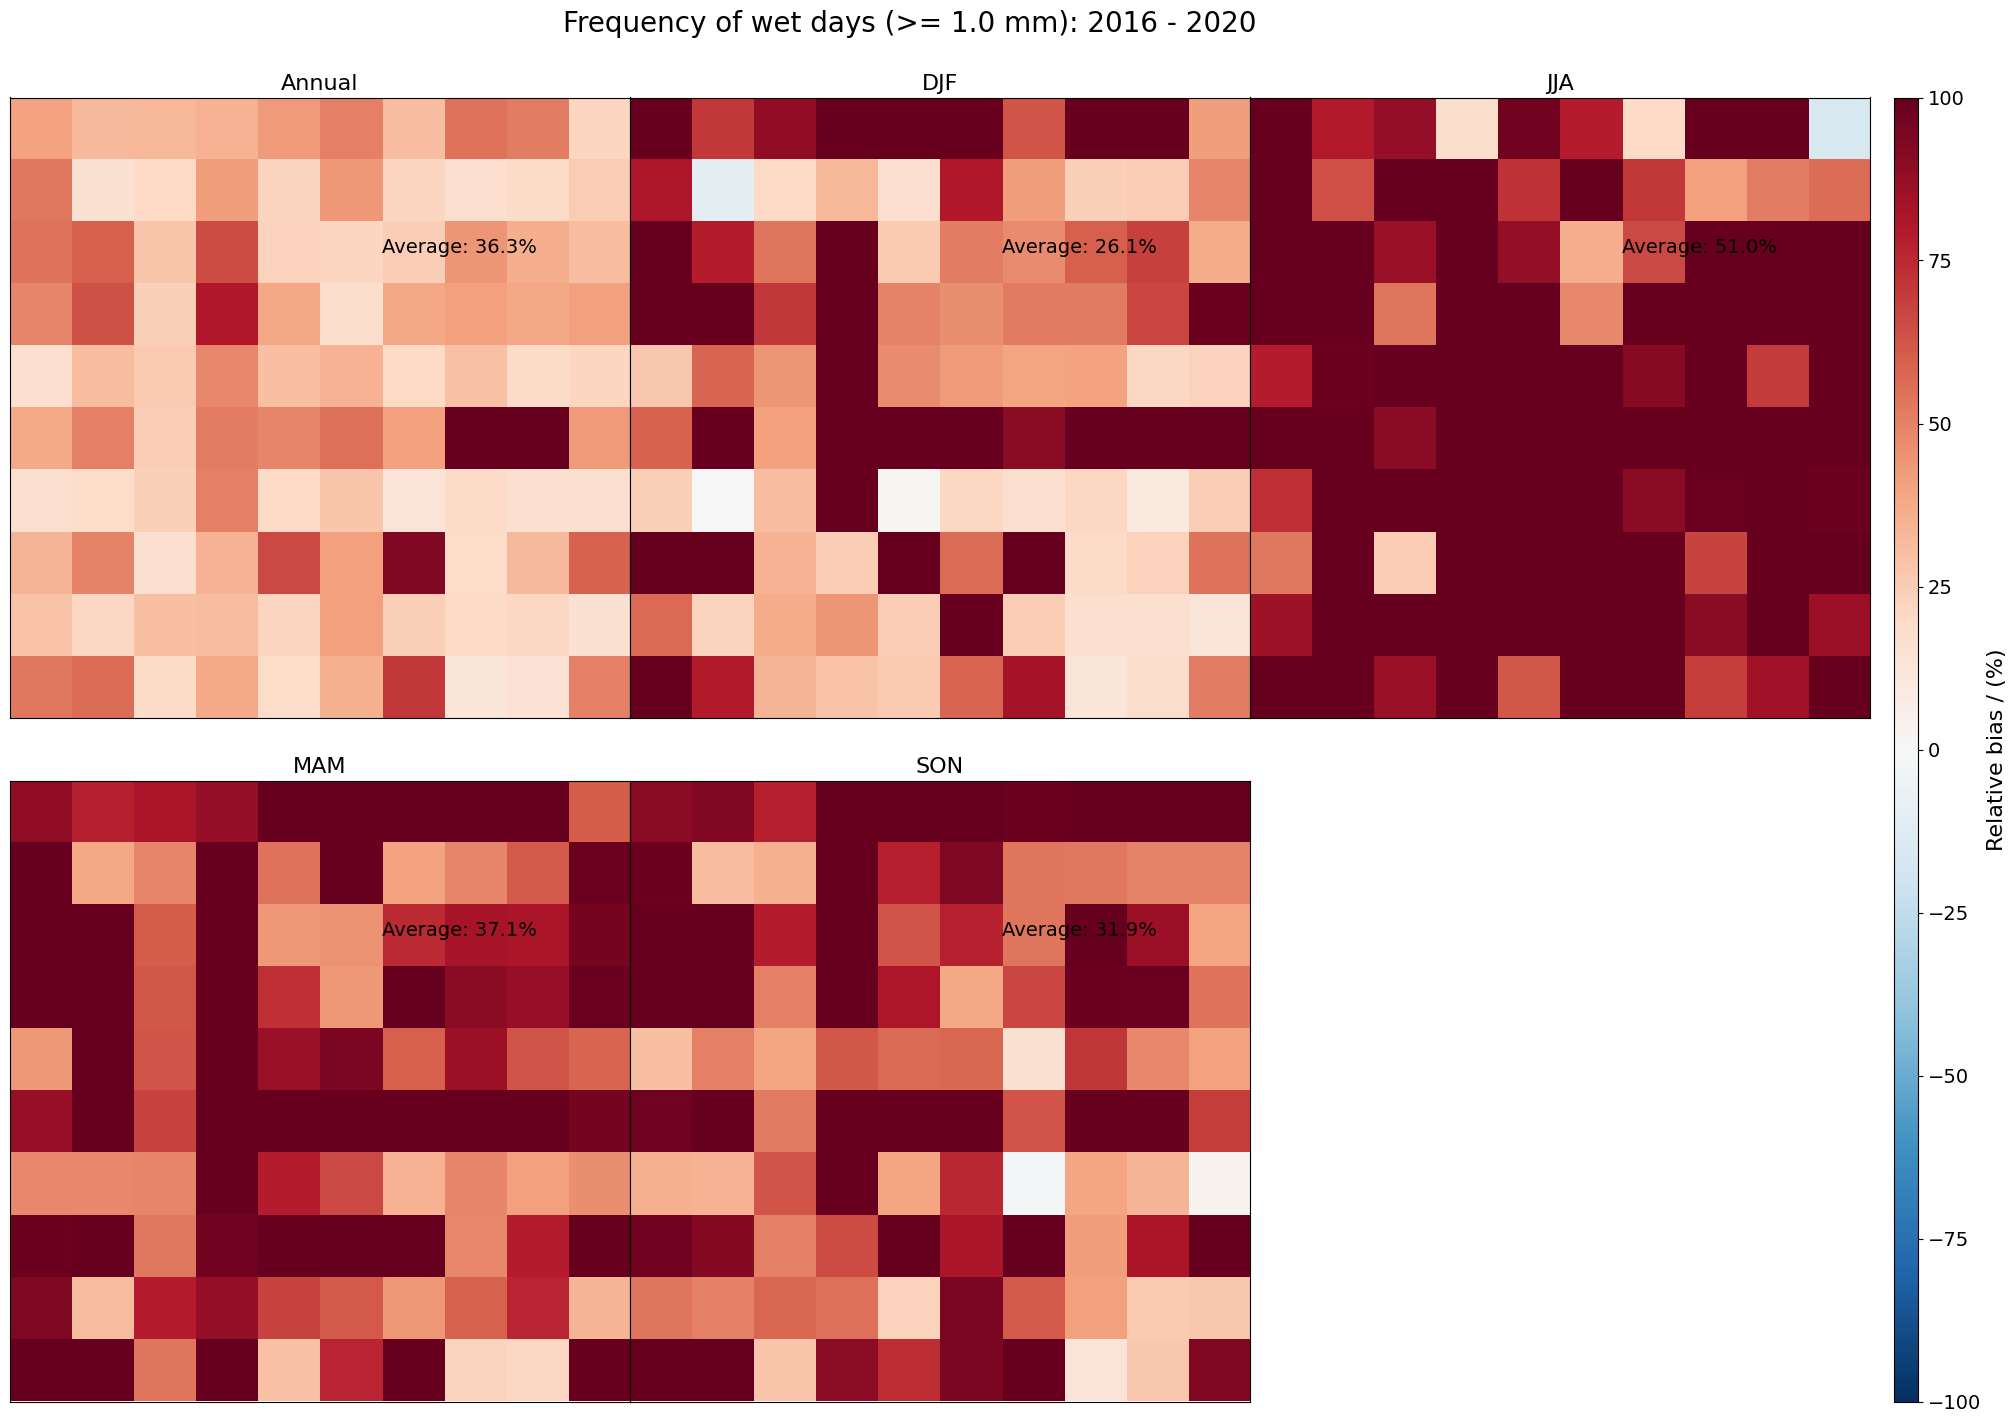

In [60]:
# plot average of observation, prediction, and bias
fig, axes = plt.subplots(2, 3, figsize=(24, 16), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias of extreme
ds = bias_wet
im = axes[0].imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-100, vmax=100)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias of extreme
for ax, season in zip(axes[1:], bias_wet_snl.season):
    ds = bias_wet_snl.sel(season=season)
    ax.imshow(ds.values, origin='upper', cmap='RdBu_r', vmin=-40, vmax=40)
    ax.set_title(season.item(), fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
# turn off last axis
axes[-1].set_visible(False)

# adjust figure
fig.suptitle('Frequency of wet days (>= {:.1f} mm): {} - {}'.format(WET_DAY_THRESHOLD, start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0.1, wspace=0, top=0.925)

# add colorbar
cbar_ax_predictand = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                                   0.01, axes[0].get_position().y1 - axes[-1].get_position().y0])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand)
cbar_predictand.set_label(label='Relative bias / (%)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
#fig.savefig('../Notebooks/Figures/{}_bias_wet_day.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Mean wet day precipitation

In [61]:
# calculate mean wet day precipitation
dii_true = (y_true * wet_days_true).sum(dim='time', skipna=False) / n_wet_days_true
dii_pred = (y_pred_pr * wet_days_pred).sum(dim='time', skipna=False) / n_wet_days_pred

In [62]:
# calculate relative bias of mean wet day precipitation
bias_dii = ((dii_pred - dii_true) / dii_true) * 100

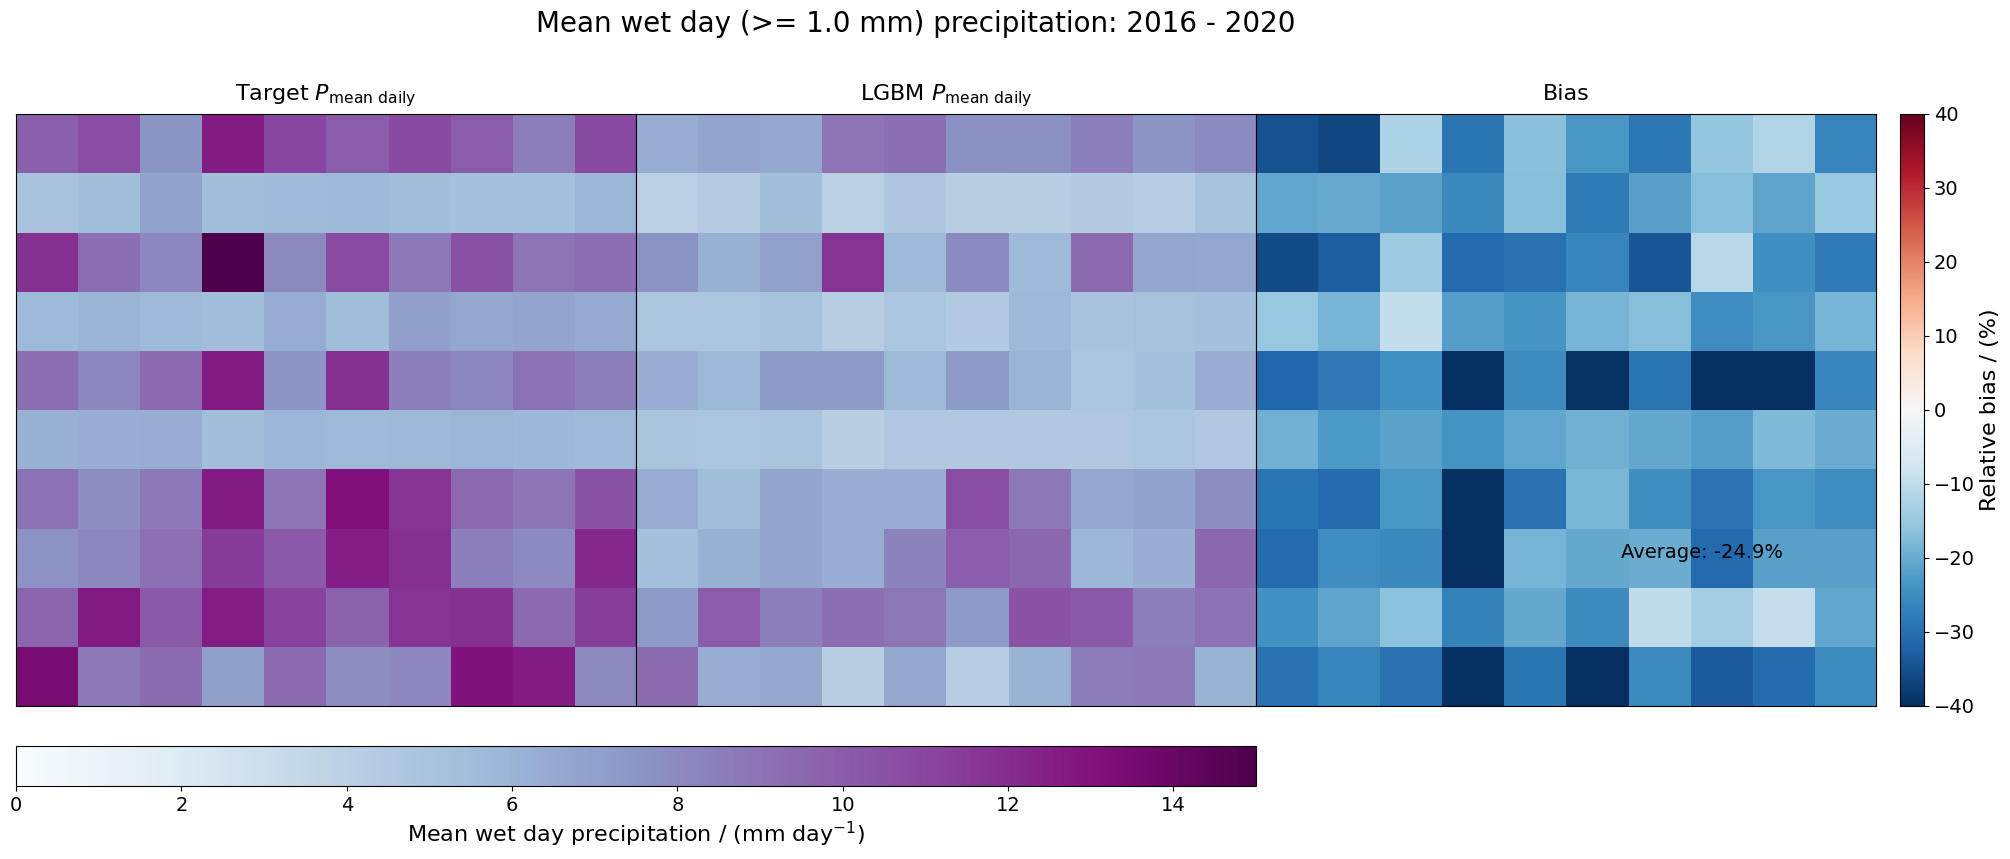

In [63]:
# plot average of observation, prediction, and bias
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
for ds, ax in zip([dii_true, dii_pred, bias_dii], axes):
    if ds is bias_dii:
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-40, vmax=40)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.1f}%'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.values, origin='upper', cmap='BuPu', vmin=0, vmax=15)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Mean wet day (>= {:.1f} mm) precipitation: {} - {}'.format(WET_DAY_THRESHOLD, start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Relative bias / (%)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='Mean wet day precipitation / (mm day$^{-1}$)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
#fig.savefig('../Notebooks/Figures/{}_bias_wdp.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

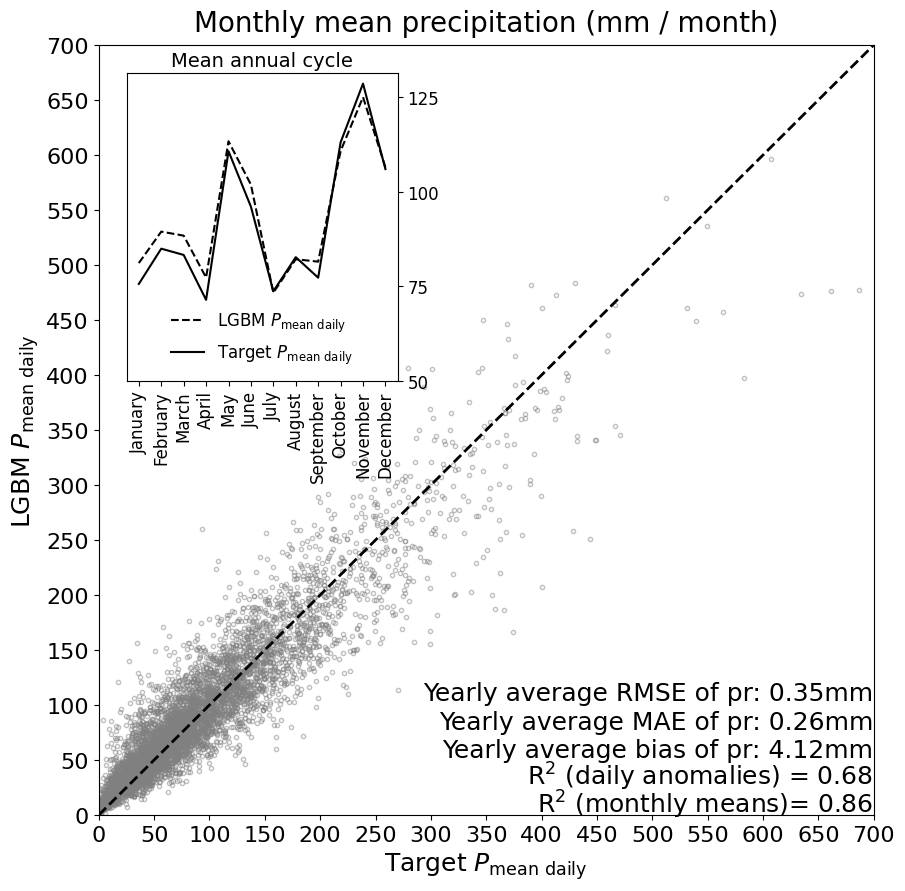

In [64]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot only a subset of data: otherwise plot is overloaded ...
# subset = np.random.choice(np.arange(0, len(y_pred_values)), size=int(1e3), replace=False)
# ax.plot(y_true_values[subset], y_pred_values[subset], 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot 1:1 mapping line
interval = np.arange(0, 750, 50)
ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 2, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 27.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 53, s='Yearly average bias of {}: {:.2f}mm'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 78.5, s='Yearly average MAE of {}: {:.2f}mm'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 104, s='Yearly average RMSE of {}: {:.2f}mm'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel(TRUE, fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (mm / month)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=2)
axins.plot(y_pred_ac, ls='--', color='k', label=PRED)
axins.plot(y_true_ac, ls='-', color='k', label=TRUE)
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.set_yticks(np.arange(50, 150, 25))
axins.set_yticklabels(np.arange(50, 150, 25), fontsize=12)
axins.yaxis.tick_right()
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

# save figure
#fig.savefig('../Notebooks/Figures/{}_r2.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')